<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/5_6_Mixture_Density_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

## MIXTURE DENSITY NETWORK
 ref: http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/
  https://www.katnoria.com/mdn/

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import math

device = 'cuda:0'
torch.__version__

'1.13.1+cu116'

### Inverse Problem

- Normal linear regression

In [ ]:
def create_book_example(n=1000):
    # Train 데이터 준비
    x_data = np.float32(np.random.uniform(-10.5, 10.5, (1, n))).T
    r_data = np.float32(np.random.normal(size=(n,1)))
    yn_data = np.float32(np.sin(0.75*x_data)*7.0 + x_data*0.5)
    y_data = np.float32(np.sin(0.75*x_data)*7.0 + x_data*0.5 + r_data*1.0)
    # Test 데이터 준비
    x_test = np.float32(np.arange(-10.5,10.5,0.05))
    x_test = x_test.reshape(x_test.size, 1)
    return x_data, y_data, x_test

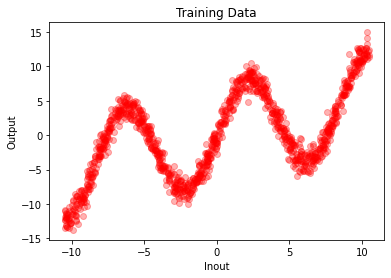

In [ ]:
# Plot data (x and y)
X, y, x_test = create_book_example(n=1200)
plt.plot(X, y, 'ro', alpha=0.3)
plt.title("Training Data")
plt.xlabel('Inout')
plt.ylabel('Output')
plt.show()

In [ ]:
class CustomDataset:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self): return len(self.x)
    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx]).to(device),\
               torch.FloatTensor(self.y[idx]).to(device)

In [ ]:
trainDataset = CustomDataset(X, y)
trainDataLoader = DataLoader(trainDataset, shuffle=False, batch_size=16)

In [ ]:
# MLP Regression model
class MLP(pl.LightningModule):
    def __init__(self, h):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, h),
            nn.PReLU(h),
            nn.Linear(h, 1))

    def forward(self, x):
        out = self.layers(x)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y)
        metrics={'loss':loss}
        self.log_dict(metrics,on_step=False,on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y)
        metrics = {'val_loss':loss}
        self.log_dict(metrics,on_step=False,on_epoch=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y)
        metrics = {'test_loss':loss}
        self.log_dict(metrics)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

model = MLP(h=32).to(device)
summary(model, input_size=(4, 1))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [4, 1]                    --
├─Sequential: 1-1                        [4, 1]                    --
│    └─Linear: 2-1                       [4, 32]                   64
│    └─PReLU: 2-2                        [4, 32]                   32
│    └─Linear: 2-3                       [4, 1]                    33
Total params: 129
Trainable params: 129
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [ ]:
%%time
logger = CSVLogger("logs", name="MLP")
trainer = Trainer(max_epochs=200, logger=logger)
trainer.fit(model, trainDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/MLP/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 129   
--------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
/usr/local/l

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.


CPU times: user 55.9 s, sys: 1.4 s, total: 57.3 s
Wall time: 1min


Epoch 199: 100% 75/75 [00:00<00:00, 106.20it/s, loss=1.47, v_num=13]  
CPU times: user 2min 10s, sys: 3.96 s, total: 2min 14s  
Wall time: 2min 28s

In [ ]:
import pandas as pd
import os

In [ ]:
testDataset = CustomDataset(x_test, y)
testDataLoader = DataLoader(testDataset, shuffle=False)

In [ ]:
# model train_logdir 확인
v_num = model.logger.version
log_dir = f'logs/MLP/version_{v_num}'

metrics = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))
plt.plot(metrics.groupby('epoch').mean()['loss'], linestyle='--', label="train_loss")

plt.semilogy()
plt.legend()
plt.grid()
plt.show()

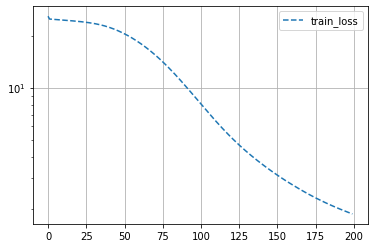

In [ ]:
# Prediction
model.eval()
y_test = model.to(device)(torch.FloatTensor(x_test).to(device)).cpu().detach().numpy()
# plot results
plt.plot(X, y, 'ro', alpha=0.3, label='Training Data')
plt.plot(x_test, y_test, 'bo', alpha=0.2, label='Regression Result')
plt.legend()
plt.title('Regression Results ')
plt.show()

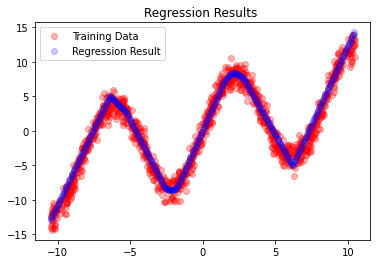

- Inverse problem

(1200, 1) (1200, 1)


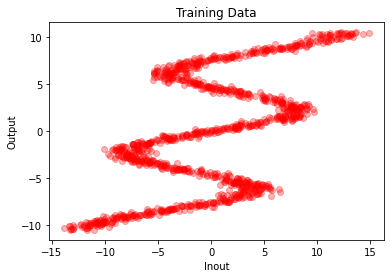

In [ ]:
# Plot data (x and y)
X, y, x_test = create_book_example(n=1200)
print(X.shape, y.shape)
flipped_x = y
flipped_y = X

plt.plot(flipped_x, flipped_y, 'ro', alpha=0.3)
plt.title("Training Data")
plt.xlabel('Inout')
plt.ylabel('Output')
plt.show()

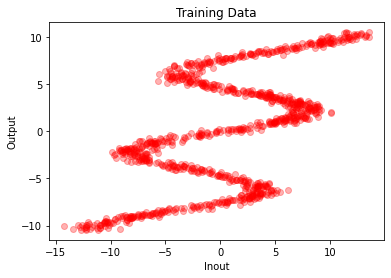

In [ ]:
%%time
model = MLP(h=32).to(device)
trainDataset = CustomDataset(flipped_x, flipped_y)
trainDataLoader = DataLoader(trainDataset, shuffle=False, batch_size=1)
logger = CSVLogger("logs", name="MLP_flipped")
trainer = Trainer(max_epochs=50, logger=logger, accelerator='auto')
trainer.fit(model, trainDataLoader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 129   
--------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 2min 51s, sys: 4.17 s, total: 2min 55s
Wall time: 3min 8s


In [ ]:
# model train_logdir 확인
v_num = model.logger.version
log_dir = f'logs/MLP_flipped/version_{v_num}'

metrics = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))
plt.plot(metrics.groupby('epoch').mean()['loss'], linestyle='--', label="train_loss")

plt.semilogy()
plt.legend()
plt.grid()
plt.show()

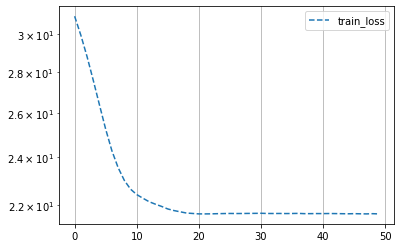

In [ ]:
# epochs 500
x_test_inv = np.linspace(-12, 12., 500).reshape(-1, 1)
y_test_inv = model.to(device)(torch.FloatTensor(x_test_inv).to(device)).cpu().detach().numpy()

plt.plot(y, X, 'ro', alpha=0.3)
plt.plot(x_test_inv, y_test_inv, 'b.', alpha=0.3)
plt.show()

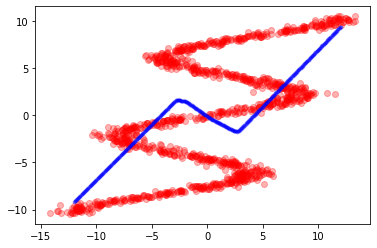

### Mixture Density Network

- 5개의 component를 갖는 Model

In [ ]:
# Mixture Density Network model
f = 1 # features
hidden = 50 # hidden layer
k = 5 # components
class MixtureDensity(pl.LightningModule):
    def __init__(self, print_every):
        super(MixtureDensity, self).__init__()
        self.print_every = print_every
        self.layer = nn.Sequential(
                         nn.Linear(f, hidden),
                         nn.Tanh())
        self.mu_layer  = nn.Linear(hidden, k)
        self.var_layer = nn.Linear(hidden, k)
        self.pi_layer  = nn.Sequential(
            nn.Linear(hidden, k),
            nn.Softmax())
    def forward(self, x):
        out = self.layer(x)
        mu = self.mu_layer(out)
        var = self.var_layer(out)
        var = torch.exp(var) # 양수값이므로 exp를 취해줌
        pi = self.pi_layer(out)
        return pi, mu, var

    ## 학습된 확률함수와 y_true의 likelihood를 계산,
    ## y_true와 5개 정규분포로 부터 y의 확률을 계산
    def calc_pdf(self, y, mu, var): #(n, 5, 5)
        """Calculate component density"""
        value = (y - mu)** 2 #
        value = torch.exp(-value/(2*var))
        value = 1/torch.sqrt(2* torch.pi * var) * value
        return value #각 y에 대한 5개의 확률값:(n, 5)

    ## 예측한 밀도함수 N(mu,var)에서 y확률밀도를 계산하고,
    ## -log(likelihood) & recuce_sum -> loss
    def mdn_loss(self, y_true, pi, mu, var):   #(n,5,5,5)
        out = self.calc_pdf(y_true, mu, var)   #(n,5)<-(n,5,5)
        out = torch.multiply(out, pi) # 확률에 가중치를 곱 #(n,5)
        out = torch.sum(out, 1, keepdim=True)  #(n,1)
        out = -torch.log(out + 1e-10)          # -log(n,1)
        return torch.mean(out)                 #(1,)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        pi, mu, var = self.to(device)(x)
        loss = self.mdn_loss(y, pi, mu, var)
        self.log(value=loss, name='loss',on_step=False,on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x, y = x.to(device), y.to(device)
        pi, mu, var = self.to(device)(x)
        loss = self.mdn_loss(y, pi, mu, var)
        self.log(value=loss, name='val_loss')
        return loss

    def configure_optimizers(self):
        return torch.optim.RMSprop(self.parameters())

    def on_train_epoch_end(self):
        if (self.trainer.current_epoch + 1) % self.print_every == 0:
            self.training_result_plot()

    def sample_predictions(self, pi_vals, mu_vals, var_vals, samples=10):
        n, k = pi_vals.shape  # n:420, k:5
        out = np.zeros((n, samples, f)) # (420,10,1)
        for i in range(n): # #in_sample(420)
            for j in range(samples):#aug_sample(10)
                # pi 샘플링: pi[i]에 있는 확률로 하나 선택
                #         : k선택, 샤용할 mu, var 선택
                idx = np.random.choice(range(k), p=pi_vals[i])
                for li in range(f):
                    #정규분포에서 (mu[i번째x에대한][idx],var[i번째x에대한][idx])
                    #            로 샘플링
                    out[i,j,li] = np.random.normal(mu_vals[i, idx*(li+f)],
                                                   np.sqrt(var_vals[i, idx]))
        return out #out[i번째x에대한,j번째샘플,li번째feature]:(420,10,1)

    #중간결과 보여 주기
    def training_result_plot(self):
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(12,3))
        epoch = self.trainer.current_epoch
        # Get predictions, Get samples
        x_test_tensor = torch.FloatTensor(x_test).to(device)
        pi_vals, mu_vals, var_vals = self(x_test_tensor) #[(420,5),(420,5),(420,5)]
        sampled_predictions = self.sample_predictions(pi_vals.cpu().detach().numpy(),
                                                      mu_vals.cpu().detach().numpy(),
                                                      var_vals.cpu().detach().numpy(), 10)

        ax1.plot(flipped_x, flipped_y, 'ro', alpha=0.1)
        for i in range(sampled_predictions.shape[1]):
            ax1.plot(x_test, sampled_predictions[:, i], 'b.', alpha=0.1, label='predicted')
        ax1.axis([-12, 12, -12, 12])
        ax1.set_title(("[%d] Sampled Results") % (epoch))

        ax2.plot(x_test, mu_vals.cpu().detach().numpy(), label="Mean Functions")
        ax2.set_title(("[%d] Means : Mu(x)") % (epoch))
        ax2.axis([-12, 12, -12, 12])

        ax3.plot(x_test, pi_vals.cpu().detach().numpy(), label="Mix Functions")
        ax3.set_title(("[%d] Mixing Coeff. Pi(x)") % (epoch))

        ax4.plot(x_test, var_vals.cpu().detach().numpy(), label="Var Functions")
        ax4.set_title(("[%d] Variance Coeff. Var(x)") % (epoch))

        ax1.grid(True)
        ax2.grid(True)
        ax3.grid(True)
        plt.show()
        return var_vals

print_every = 500
model = MixtureDensity(print_every).to(device)
summary(model, input_size=(8, 1))

Layer (type:depth-idx)                   Output Shape              Param #
MixtureDensity                           [8, 5]                    --
├─Sequential: 1-1                        [8, 50]                   --
│    └─Linear: 2-1                       [8, 50]                   100
│    └─Tanh: 2-2                         [8, 50]                   --
├─Linear: 1-2                            [8, 5]                    255
├─Linear: 1-3                            [8, 5]                    255
├─Sequential: 1-4                        [8, 5]                    --
│    └─Linear: 2-3                       [8, 5]                    255
│    └─Softmax: 2-4                      [8, 5]                    --
Total params: 865
Trainable params: 865
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params
-----------------------------------------
0 | layer     | Sequential | 100   
1 | mu_layer  | Linear     | 255   
2 | var_layer | Linear     | 255   
3 | pi_layer  | Sequential | 255   
-----------------------------------------
865       Trainable params
0         Non-trainable params
865    

Training: 0it [00:00, ?it/s]

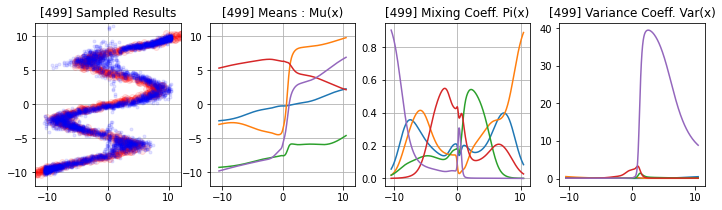

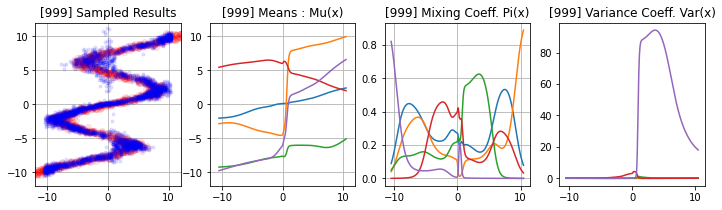

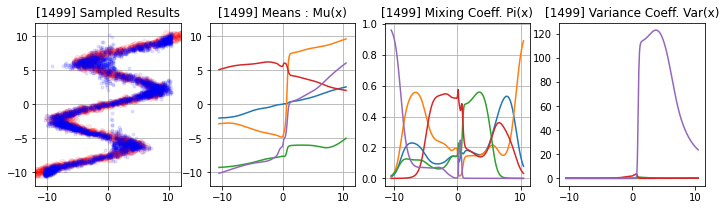

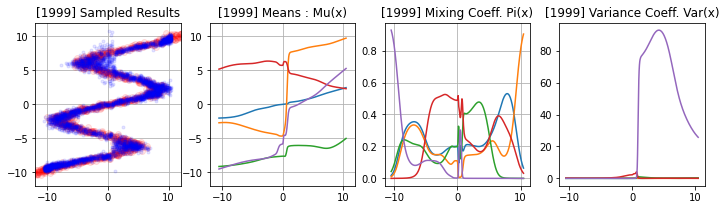

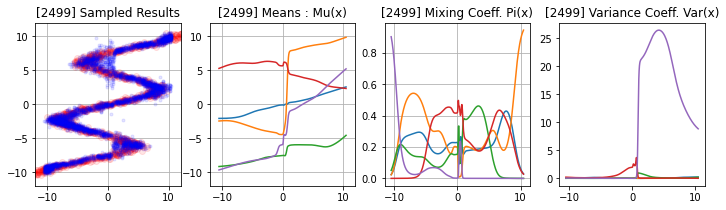

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=2500` reached.


CPU times: user 3min 42s, sys: 5.17 s, total: 3min 47s
Wall time: 4min 4s


In [ ]:
%%time
print_every = 500
model = MixtureDensity(print_every)

trainDataset = CustomDataset(flipped_x, flipped_y)
trainDataLoader = DataLoader(trainDataset, batch_size=512, shuffle=True)
logger = CSVLogger("logs", name="MDN_model")
trainer = Trainer(max_epochs=2500, logger=logger, accelerator='auto')
trainer.fit(model, trainDataLoader)

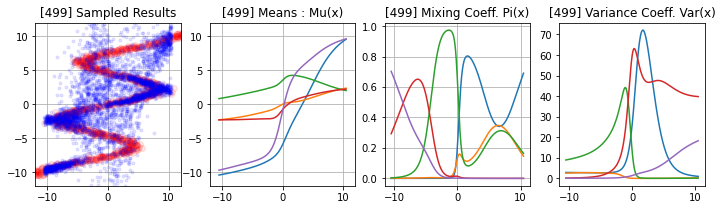  
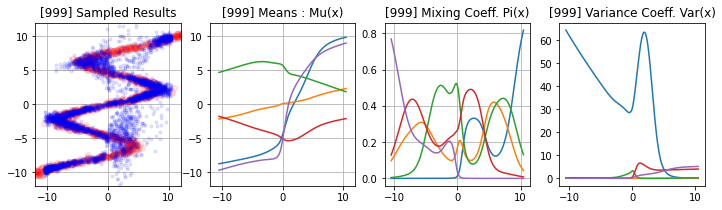  
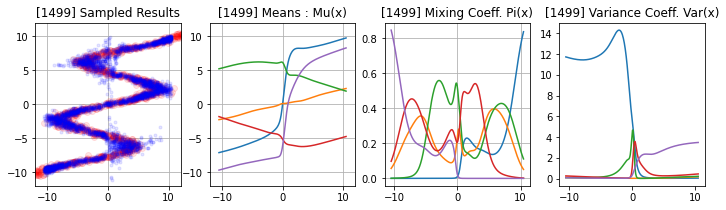  
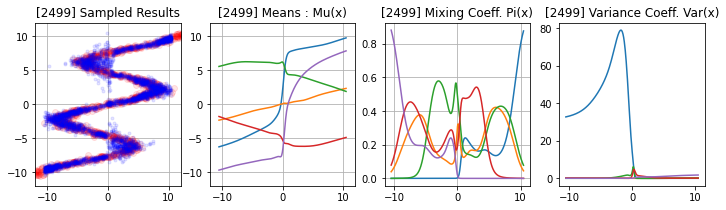  
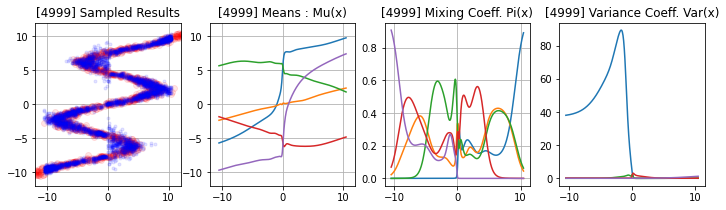

CPU times: user 5min 32s, sys: 10.5 s, total: 5min 43s  
Wall time: 6min 22s

In [ ]:
torch.onnx.export(model.to(device), torch.zeros((8, 1)).to(device), 'MixtureDensityNetwork.onnx')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1110: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*input, **kwargs)


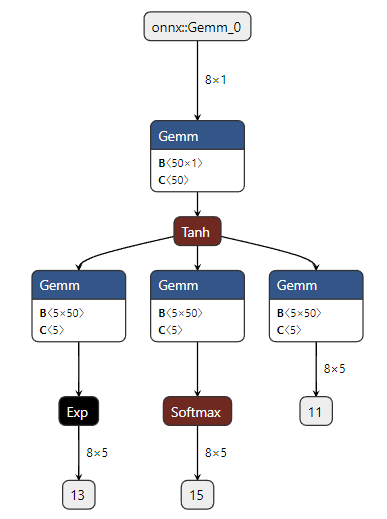

### Plot Loss

In [ ]:
# model train_logdir 확인
v_num = model.logger.version
log_dir = f'logs/MDN_model/version_{v_num}'

metrics = pd.read_csv(os.path.join(log_dir, 'metrics.csv'))
plt.plot(metrics.groupby('epoch').mean()['loss'], linestyle='--', label="train_loss")

plt.semilogy()
plt.legend()
plt.grid()
plt.show()

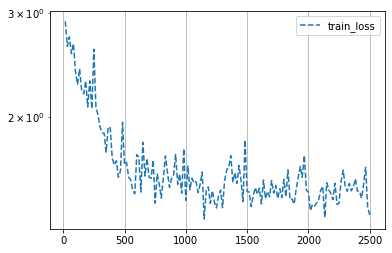

- Sampling
**학습된 확률분포에 x_test값을 넣어 sampling된 y_pred 구하기

In [ ]:
# Plot the predictions along with the flipped data
import matplotlib.patches as mpatches

# Prediction으로 확률 parameter 산출   #(420,5)x3 <- (420)
pi_vals, mu_vals, var_vals = model(torch.Tensor(x_test))
# 5개 확률분포에서 중요도에 따라 10개 sampling 하기
pi_vals = pi_vals.cpu().detach().numpy()
mu_vals = mu_vals.cpu().detach().numpy()
var_vals = var_vals.cpu().detach().numpy()
sampled_predictions = model.sample_predictions(pi_vals, mu_vals, var_vals, 10)
#sampled_predictions.shape : (420,10,1)
fig = plt.figure(figsize=(6, 6))
plt.plot(flipped_x, flipped_y, 'ro')#training data
for i in range(sampled_predictions.shape[1]): # 10
     plt.plot(x_test, sampled_predictions[:, i], 'b.', alpha=0.3, label='predicted')
patches = [ mpatches.Patch(color='red', label='Training'),
            mpatches.Patch(color='blue', label='Predicted') ]
plt.legend(handles=patches)
plt.show()

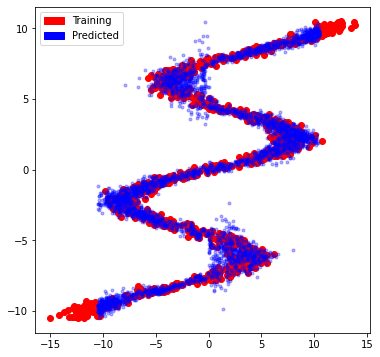

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(flipped_x, flipped_y, 'ro', alpha=0.1)
for i in range(sampled_predictions.shape[1]):
     p1=plt.plot(x_test, sampled_predictions[:, i], 'b.', alpha=0.1, label='predicted')
p2=plt.plot(x_test, mu_vals, linewidth=3)
#p3=plt.plot(x_test, (pi_vals*30-15))
plt.axis([-13, 13, -13, 13])
plt.title("Mean Functions")
plt.xlabel("Input")
plt.ylabel("Output")
#plt.grid(True)
plt.legend(loc='best')
plt.show()

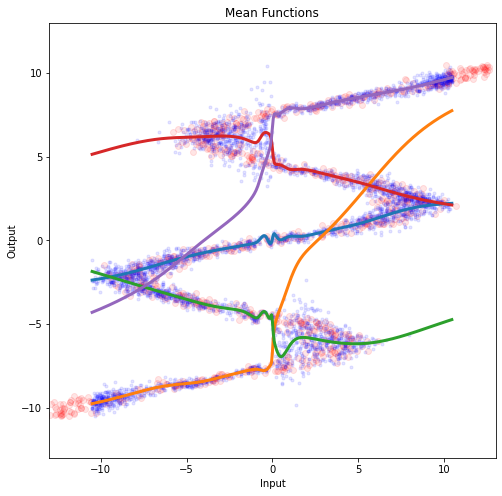